In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline
from xgboost import XGBClassifier
import lightgbm as lgb
import joblib
import logging
import optuna


%load_ext autoreload
%aimport plotMethods
%autoreload 1

np.random.seed(42) 

# Uplift modeling - which customers to target?

Modern world is full of advertisements and those are becoming more and more targeted. To win our attention, companies adapt to e.g. our digital viewing habits, collect our demographic data and then use this information to sell us things they think we may like. By focusing on specific traits, interests and preferences of a customer, targeted marketing is trying to **maximize the incremental impact of the promoted product**.

But how do these marketing campaigns identify the right individuals to send discount coupons or personalized advertisements to? Certainly, running those campaigns incurs financial costs, and it is unfeasible to send discount coupons to everyone in the world. The cost of printing the coupons and the lost of potential revenues, resulting from the offered discount, might just outweigh the additional profits generated from new customers. In addition, what if the customer was already planning to buy the advertised coupon, without receiving any extra discounts or adverts? In that case, the retailer would generate less profit, as the customer will be paying less than what they already intended to pay. So how do you identify individuals who are **only likely to purchase** your product **if targeted by the marketing campaign**?

## Dataset

Here, we will be using data provided by *Udacity* as part of their *Data Scientist Nanodegree*. This dataset was originally used as a take-home assignment given out by Starbucks during job application process. The data consists of about 120,000 data points split in a 2:1 ratio between training and testing sets. In the experiment, simulated by the data, Starbucks is about to launch a new marketing campaign based on sending promotional materials to selected customers. The team has run a randomized pilot (A/B testing) to test this campaign. In the pilot, a subset of customers was divided into two groups, only one of which received the promotion. The team recorded each customer's buying decision along with 7 features (*V1-V7*) encoding their personal characteristics. Based on the gathered data, we now want to know which other customers should be assigned to this campaign, in a way that would maximize generated profit. Since it costs the company *0.15* to contact each person, it would be best to limit the campaign only to the most receptive customers. As such, rather than predicting which customers would buy the product, we want to predict which customers would buy the product **only if contacted** (interaction).

## Goal

Our goal is to maximize the **profit of the campaign**:

$profit = \sum \limits _{i=1} ^{N} 10*purchase_{i}(decision_{i}) - 0.15*decision_{i}$,

where *purchase* is a purchasing decision of an individual client influenced by the *decision* - a binary indicator of whether that person has been targeted or not.

To account for the fact that some customers buy the product even if not targeted, we should also look at the **net incremental profit**, defined as:

$NIR = profit- 10*nControlPurchase$,

where *nControlPurchase* is the number of people, who were not targeted and bought the service.

Furthermore, Starbucks asked their job candidates to also optimize the **incremental response rate**, defined as:

$IRR = \frac{nTreatPurchase}{nTreat} - \frac{nControlPurchase}{nControl}$, 

where *nTreatPurchase* is the number of people, who were not targeted and bought the service; and *nTreat* and *nControl* are the number of targeted and non-targeted customers respectively.

For this assignment, Starbucks claimed to have a model that achieved a NIR of 189.45 and an IRR of 1.88%. Note that this assignment is quite outdated though and it is very likely that Starbucks will have a better model now. Yet, these numbers will serve us as the benchmarks to beat.

## The approach

The problem of deciding whether it is profitable to target a particular customer can be tackled from two different perspectives:

1. traditional predictive modeling, where the problem is treated as a common classification task
2. uplift modeling, where the incremental probability of purchase is modeled

Here, we're gonna compare both of those perspectives and use a total of four different approaches to choosing which customers to target:

1. Traditional predictive model 
2. [S-learner model (one-model "uplift classifier")](./2.S-learner.ipynb)
3. [T-learner model (two-models "uplift classifier")](./3.T-learner.ipynb) 
4. [Direct uplift modeling](./4.Direct-uplift.ipynb)

# Traditional Predictive Model

In this notebook, we're gonna focus on the traditional predictive path, framing the task as a **classification** problem. From the collected data, the company can classify the customers into two categories: (i) those who made the purchase after being targeted and (ii) the rest. The rest will include:

1. Those who purchased the product without being targeted
2. Those who were targeted and yet did not buy the product

**Note:** the data would also contain a 4th group of customers - people who were not targeted and did not buy the product. Since we cannot know whether those people would buy the product if contacted, we do not have sufficient data to say whether they should be targeted or not. As such, we are going to simply discard that data from our model.  

In [2]:
data = pd.read_csv("data/training.csv")
# adding the target column toCall
data['toTarget'] = [1 if (treat == "Yes" and purchase == 1) else 0 for treat, 
                  purchase in zip(data['Promotion'], data['purchase'])]
data['Promotion'] = data['Promotion'].replace({'No': 0, 'Yes': 1})

## Exploratory Data Analysis

First, we need to learn a little bit more about our data - what type of variables are we working with, how many data points do we have, do we have to deal with any missing data etc. 

In [4]:
plotMethods.eda(data)

,type,count,missing,unique,mean,std,min,max,kurtosis,skew
ID,int64,84534,0,84534,62970.972413,36418.440539,1.000000,126184.000000,-1.199707,0.005485
Promotion,int64,84534,0,2,0.501147,0.500002,0.000000,1.000000,-2.000026,-0.004590
purchase,int64,84534,0,2,0.012303,0.110234,0.000000,1.000000,76.299732,8.848612
V1,int64,84534,0,4,1.500662,0.868234,0.000000,3.000000,-0.673422,0.000404
V2,float64,84534,0,84518,29.973600,5.010626,7.104007,50.375913,0.021425,-0.011369
V3,float64,84534,0,40,0.000190,1.000485,-1.684550,1.691984,-1.205420,0.004073
V4,int64,84534,0,2,1.679608,0.466630,1.000000,2.000000,-1.407398,-0.769828
V5,int64,84534,0,4,2.327643,0.841167,1.000000,4.000000,-0.743953,-0.059024
V6,int64,84534,0,4,2.502898,1.117349,1.000000,4.000000,-1.358416,-0.003446
V7,int64,84534,0,2,1.701694,0.457517,1.000000,2.000000,-1.222616,-0.881710


We have 11 variables - 7 Vs corresponding to customers' features, an information on whether the customer has been targeted in the A/B test (Promotion), customer's purchase decision (purchase), customer's ID and finally the (added) target variable indicating whether the customer should be target in the new marketing campaign. The customer ID should be a random value assigned to the customer for identification purposes, it won't be helpful to us here. We have **no categorical features** and **no missing data**, we do have a couple of **binary variables** and 3 further **integer variables**, that may potentially be ordinal. The features are not labeled purposefully, as Strabucks wanted the job candidates to focus solely on the analytical process without being able to benefit from business insights. 

But before we take a closer look at all that, let's check our **Promotion** and **purchase** columns. What is the outcome of our A/B testing? Is our marketing campaign working?

In [3]:
data.columns = ['ID', 'promotion', 'purchase', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'toTarget']

chi, p, _, _ = stats.chi2_contingency(pd.crosstab(data['purchase'], data['promotion']))
print("\n Chi square test of independence - chi2: {}, p-value: {} \n".format(chi, p))
origProfit = pd.crosstab(data['purchase'], data['promotion'], margins=True, margins_name="total")
origProfit


 Chi square test of independence - chi2: 154.6851420820884, p-value: 1.6405910232768956e-35 



promotion,0,1,total
purchase,,,
0,41851,41643,83494
1,319,721,1040
total,42170,42364,84534


All right, so from our group of 84534 customers, approximately 50% (42364) were targeted during the A/B testing. Out of those about 2% (721) purchased the product. Additional 319 purchases were made by non-targeted customers (~1% of all non-targeted customers). Statistical testing *(chi square test of independence)* reveals that there is a **significant relationship between the purchase and treatment variables**, suggesting that the new campaign is indeed working. 

What is important to note is that we are working with a **highly imbalanced dataset**. This is going to affect the metric we choose for model evaluation. We may also want to upsample/downsample our data.

Let's have a look at what profit generated by this campaign.

In [5]:
profit = 10*1040 - 0.15*42364
NIR = profit - 10*319
IRR = 721/42364 - 319/41851

print("profit: {:.2f}, NIR: {:.2f}, IRR: {:.2f}%".format(profit, NIR, IRR*100))

profit: 4045.40, NIR: 855.40, IRR: 0.94%


The campaign generated a NIR of 855.4 and IRR of 1%. Can we do better?

In [4]:
# discard not-targeted customers that did not buy the service
dataNoControl = data.query('promotion == 1 or purchase == 1').reset_index(drop=True)
plotMethods.eda(dataNoControl)

,type,count,missing,unique,mean,std,min,max,kurtosis,skew
ID,int64,42683,0,42683,62879.700091,36300.538831,8.000000,126181.000000,-1.191523,0.009204
promotion,int64,42683,0,2,0.992526,0.086128,0.000000,1.000000,128.825269,-11.437624
purchase,int64,42683,0,2,0.024366,0.154183,0.000000,1.000000,36.070686,6.170008
V1,int64,42683,0,4,1.504510,0.868165,0.000000,3.000000,-0.673179,-0.002690
V2,float64,42683,0,42680,29.970426,5.028071,7.104007,49.823708,0.037013,-0.009172
V3,float64,42683,0,40,0.008052,0.997904,-1.684550,1.691984,-1.200817,-0.007980
V4,int64,42683,0,2,1.679053,0.466846,1.000000,2.000000,-1.411610,-0.767109
V5,int64,42683,0,4,2.324907,0.840220,1.000000,4.000000,-0.749855,-0.064639
V6,int64,42683,0,4,2.504112,1.117107,1.000000,4.000000,-1.357848,-0.004708
V7,int64,42683,0,2,1.701380,0.457658,1.000000,2.000000,-1.225505,-0.880086


All right, we have discarded the customers that were not targeted and did not buy the product. Let's have a closer look at the distributions of our variables.

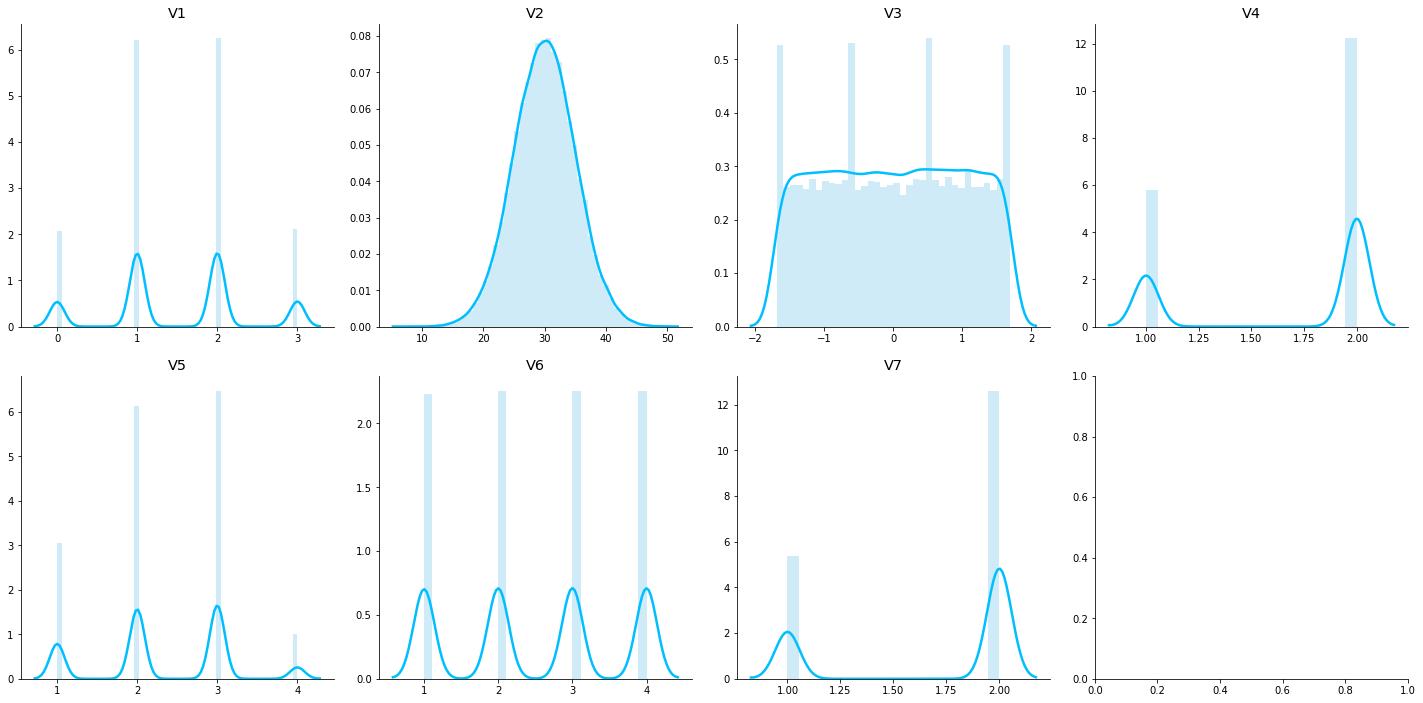

In [7]:
f, axes = plt.subplots(2, 4, figsize=(20,10), sharex=False)
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
for ax, feature in zip(axes.flat, data.iloc[:,3:-1].select_dtypes(exclude='object').columns):
    sns.distplot(dataNoControl[feature], kde_kws = {"color": "deepskyblue"}, 
                 hist_kws = {"color": "skyblue"}, ax=ax)
    sns.despine()
    ax.set(title=feature)
    ax.set(xlabel=None)
plt.tight_layout()

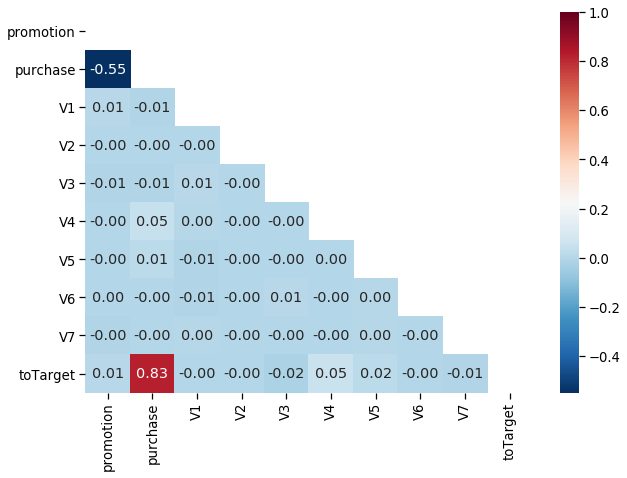

In [8]:
fig, ax = plt.subplots(figsize=(10,7))
mask = np.triu(dataNoControl.iloc[:,1:].corr()) # mask to display only lower triangle of the heatmap
sns.heatmap(dataNoControl.iloc[:,1:].corr(method='spearman'), annot=True, mask=mask, ax=ax, fmt=".2f", cmap="RdBu_r")

From the heatmap, we can see that most of the numerical are rather poorly correlated with our target variable *toTarget*. We can also see that there is very little colinearity between the features themselves.

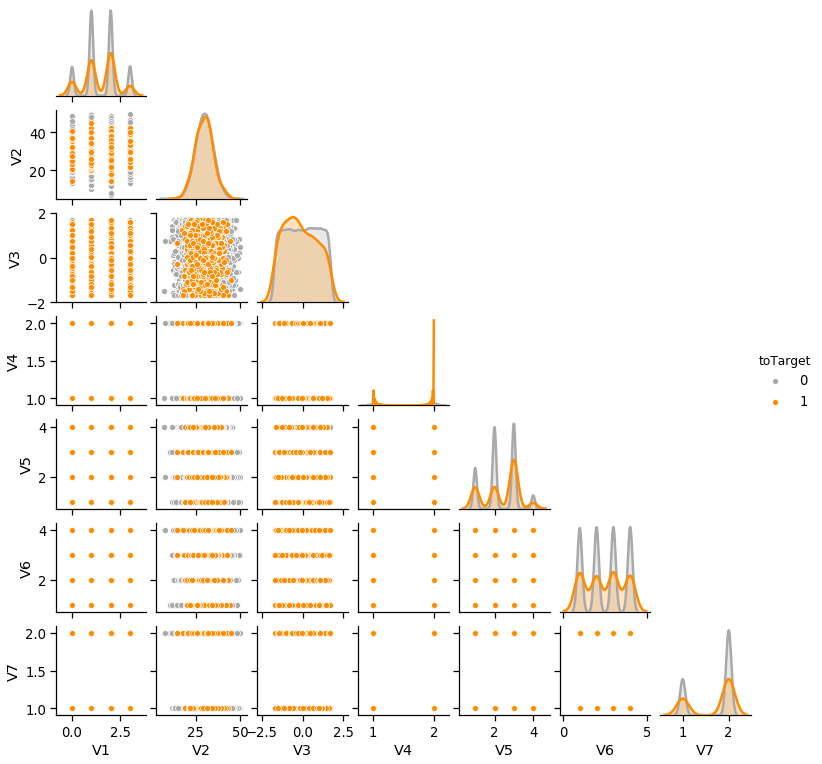

In [9]:
g = sns.pairplot(dataNoControl, vars=dataNoControl.select_dtypes(exclude='object').columns[3:-1], 
                 hue="toTarget", corner=True, height=1.5, palette = {0: 'darkgray', 1: 'darkorange'})

V1,0,1,2,3
toTarget,,,,
0,5225,15678,15701,5358
1,98,252,302,69


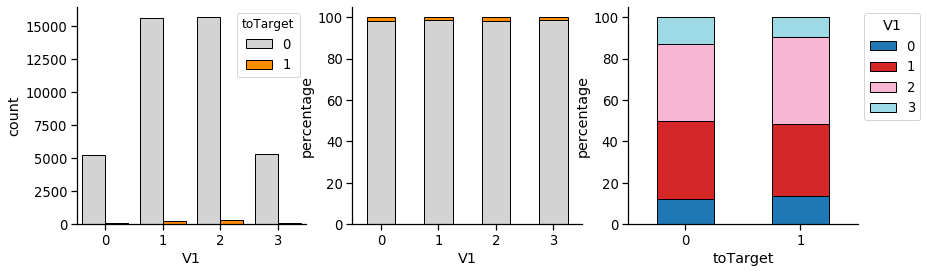

In [10]:
crossV1 = pd.DataFrame(pd.crosstab(dataNoControl['V1'], dataNoControl['toTarget'], normalize="index")*100)
crossV1target = pd.DataFrame(pd.crosstab(dataNoControl['V1'],dataNoControl['toTarget'], normalize="columns")*100).transpose()
display(pd.crosstab(dataNoControl['V1'],dataNoControl['toTarget']).transpose())

fig, ax = plt.subplots(1, 3, figsize=(14,4))
# countplot
g1 = sns.countplot(x="V1", hue="toTarget", data=dataNoControl, palette = {0: 'lightgray', 1: 'darkorange'}, 
                   saturation=1,linewidth=1, edgecolor="black", ax=ax[0])
sns.despine()
# percentage in each category
g2 = crossV1.plot(kind="bar", stacked=True, color=["lightgray", "darkorange"], edgecolor='black', ax=ax[1])
g2.spines['right'].set_visible(False)
g2.spines['top'].set_visible(False)
g2.set_xticklabels(g2.get_xticklabels(),rotation=0)
g2.set_ylabel("percentage")
g2.get_legend().remove()
# percentage of toCall
g3 = crossV1target.plot(kind="bar", stacked=True, cmap="tab20", edgecolor='black', ax=ax[2])
g3.spines['right'].set_visible(False)
g3.spines['top'].set_visible(False)
g3.set_xticklabels(g3.get_xticklabels(),rotation=0)
g3.set_ylabel("percentage")
g3.legend_.set_bbox_to_anchor((1, 1))

V4,1,2
toTarget,,
0,13604,28358
1,95,626


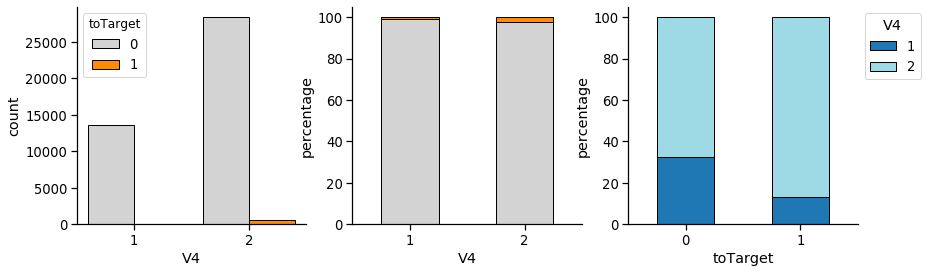

In [11]:
crossV4 = pd.DataFrame(pd.crosstab(dataNoControl['V4'], dataNoControl['toTarget'], normalize="index")*100)
crossV4target = pd.DataFrame(pd.crosstab(dataNoControl['V4'],dataNoControl['toTarget'], normalize="columns")*100).transpose()
display(pd.crosstab(dataNoControl['V4'],dataNoControl['toTarget']).transpose())

fig, ax = plt.subplots(1, 3, figsize=(14,4))
# countplot
g1 = sns.countplot(x="V4", hue="toTarget", data=dataNoControl, palette = {0: 'lightgray', 1: 'darkorange'}, 
                   saturation=1,linewidth=1, edgecolor="black", ax=ax[0])
sns.despine()
# percentage in each category
g2 = crossV4.plot(kind="bar", stacked=True, color=["lightgray", "darkorange"], edgecolor='black', ax=ax[1])
g2.spines['right'].set_visible(False)
g2.spines['top'].set_visible(False)
g2.set_xticklabels(g2.get_xticklabels(),rotation=0)
g2.set_ylabel("percentage")
g2.get_legend().remove()
# percentage of toCall
g3 = crossV4target.plot(kind="bar", stacked=True, cmap="tab20", edgecolor='black', ax=ax[2])
g3.spines['right'].set_visible(False)
g3.spines['top'].set_visible(False)
g3.set_xticklabels(g3.get_xticklabels(),rotation=0)
g3.set_ylabel("percentage")
g3.legend_.set_bbox_to_anchor((1, 1))

V5,1,2,3,4
toTarget,,,,
0,7672,15550,16228,2512
1,158,160,360,43


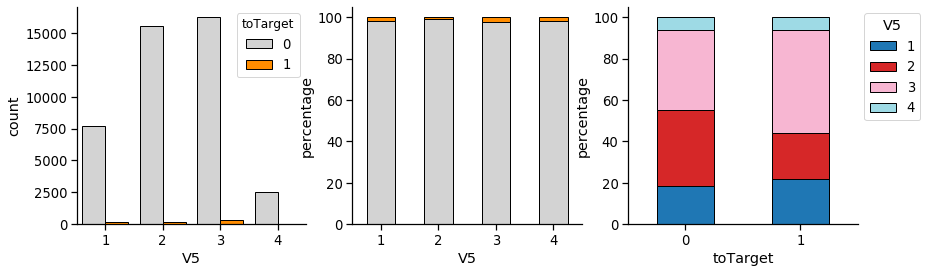

In [12]:
crossV5 = pd.DataFrame(pd.crosstab(dataNoControl['V5'], dataNoControl['toTarget'], normalize="index")*100)
crossV5target = pd.DataFrame(pd.crosstab(dataNoControl['V5'],dataNoControl['toTarget'], normalize="columns")*100).transpose()
display(pd.crosstab(dataNoControl['V5'],dataNoControl['toTarget']).transpose())

fig, ax = plt.subplots(1, 3, figsize=(14,4))
# countplot
g1 = sns.countplot(x="V5", hue="toTarget", data=dataNoControl, palette = {0: 'lightgray', 1: 'darkorange'}, 
                   saturation=1,linewidth=1, edgecolor="black", ax=ax[0])
sns.despine()
# percentage in each category
g2 = crossV5.plot(kind="bar", stacked=True, color=["lightgray", "darkorange"], edgecolor='black', ax=ax[1])
g2.spines['right'].set_visible(False)
g2.spines['top'].set_visible(False)
g2.set_xticklabels(g2.get_xticklabels(),rotation=0)
g2.set_ylabel("percentage")
g2.get_legend().remove()
# percentage of toCall
g3 = crossV5target.plot(kind="bar", stacked=True, cmap="tab20", edgecolor='black', ax=ax[2])
g3.spines['right'].set_visible(False)
g3.spines['top'].set_visible(False)
g3.set_xticklabels(g3.get_xticklabels(),rotation=0)
g3.set_ylabel("percentage")
g3.legend_.set_bbox_to_anchor((1, 1))

V6,1,2,3,4
toTarget,,,,
0,10406,10514,10512,10530
1,187,170,190,174


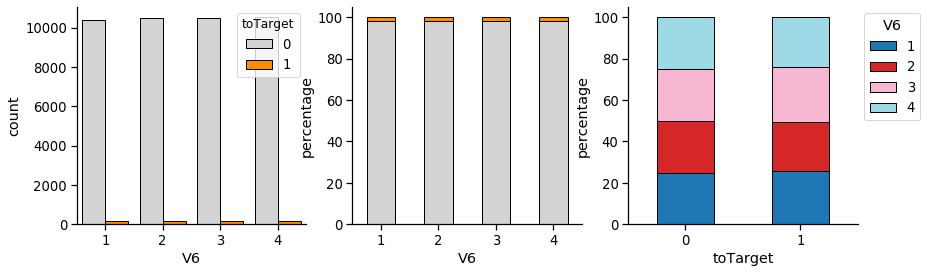

In [13]:
crossV6 = pd.DataFrame(pd.crosstab(dataNoControl['V6'], dataNoControl['toTarget'], normalize="index")*100)
crossV6target = pd.DataFrame(pd.crosstab(dataNoControl['V6'],dataNoControl['toTarget'], normalize="columns")*100).transpose()
display(pd.crosstab(dataNoControl['V6'],dataNoControl['toTarget']).transpose())

fig, ax = plt.subplots(1, 3, figsize=(14,4))
# countplot
g1 = sns.countplot(x="V6", hue="toTarget", data=dataNoControl, palette = {0: 'lightgray', 1: 'darkorange'}, 
                   saturation=1,linewidth=1, edgecolor="black", ax=ax[0])
sns.despine()
# percentage in each category
g2 = crossV6.plot(kind="bar", stacked=True, color=["lightgray", "darkorange"], edgecolor='black', ax=ax[1])
g2.spines['right'].set_visible(False)
g2.spines['top'].set_visible(False)
g2.set_xticklabels(g2.get_xticklabels(),rotation=0)
g2.set_ylabel("percentage")
g2.get_legend().remove()
# percentage of toCall
g3 = crossV6target.plot(kind="bar", stacked=True, cmap="tab20", edgecolor='black', ax=ax[2])
g3.spines['right'].set_visible(False)
g3.spines['top'].set_visible(False)
g3.set_xticklabels(g3.get_xticklabels(),rotation=0)
g3.set_ylabel("percentage")
g3.legend_.set_bbox_to_anchor((1, 1))

V7,1,2
toTarget,,
0,12518,29444
1,228,493


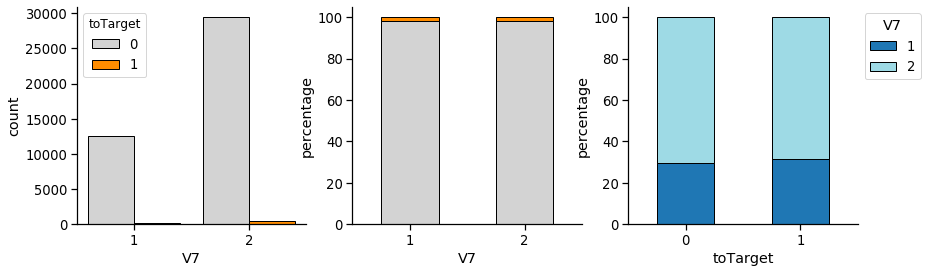

In [14]:
crossV7 = pd.DataFrame(pd.crosstab(dataNoControl['V7'], dataNoControl['toTarget'], normalize="index")*100)
crossV7target = pd.DataFrame(pd.crosstab(dataNoControl['V7'],dataNoControl['toTarget'], normalize="columns")*100).transpose()
display(pd.crosstab(dataNoControl['V7'],dataNoControl['toTarget']).transpose())

fig, ax = plt.subplots(1, 3, figsize=(14,4))
# countplot
g1 = sns.countplot(x="V7", hue="toTarget", data=dataNoControl, palette = {0: 'lightgray', 1: 'darkorange'}, 
                   saturation=1,linewidth=1, edgecolor="black", ax=ax[0])
sns.despine()
# percentage in each category
g2 = crossV7.plot(kind="bar", stacked=True, color=["lightgray", "darkorange"], edgecolor='black', ax=ax[1])
g2.spines['right'].set_visible(False)
g2.spines['top'].set_visible(False)
g2.set_xticklabels(g2.get_xticklabels(),rotation=0)
g2.set_ylabel("percentage")
g2.get_legend().remove()
# percentage of toCall
g3 = crossV7target.plot(kind="bar", stacked=True, cmap="tab20", edgecolor='black', ax=ax[2])
g3.spines['right'].set_visible(False)
g3.spines['top'].set_visible(False)
g3.set_xticklabels(g3.get_xticklabels(),rotation=0)
g3.set_ylabel("percentage")
g3.legend_.set_bbox_to_anchor((1, 1))

## Modeling

We will use our newly created *toTarget* column as the target that we want to predict. To quantify the performance of our models, we are going to split our dataset into training and dev subsets and use cross-validation to tune some of the models' parameters. The models that we are going to try are:

1. XGBoost model (boosting)
2. Random Forest model (bagging)
3. Support Vector Machine (SVM) model

In [6]:
features = list(dataNoControl.select_dtypes(exclude="object").columns[3:-1])
X = dataNoControl[features]
y = dataNoControl.toTarget
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

To reduce the computational load a bit, I am going to downsample the training set before tuning the hyperparameters. After choosing the hyperparameters, the model will be retrained on all the training data, but to make my computer's life a little bit easier, I am going to tune the hyperparameters based on 10000 observations. I will only be removing the observations coming from people that did not purchase the product.

In [7]:
NoPurch = dataNoControl.query('promotion == 1 and purchase == 0').index
commonIdx = list(set(NoPurch).intersection(Xtrain.index))
toDrop = np.random.choice(commonIdx, 28414, replace=False)
Xhyper = Xtrain.drop(toDrop)
Yhyper = Ytrain.drop(toDrop)

In [8]:
plotMethods.eda(Xhyper)

,type,count,missing,unique,mean,std,min,max,kurtosis,skew
V1,int64,10000,0,4,1.490000,0.864277,0.000000,3.000000,-0.660561,0.014577
V2,float64,10000,0,10000,29.982785,5.052445,12.020592,46.981276,-0.014044,-0.050179
V3,float64,10000,0,40,0.013742,0.999045,-1.684550,1.691984,-1.204028,-0.015574
V4,int64,10000,0,2,1.686900,0.463778,1.000000,2.000000,-1.350391,-0.806151
V5,int64,10000,0,4,2.328500,0.843243,1.000000,4.000000,-0.757247,-0.069447
V6,int64,10000,0,4,2.498500,1.117284,1.000000,4.000000,-1.358236,0.000532
V7,int64,10000,0,2,1.704000,0.456514,1.000000,2.000000,-1.201168,-0.893909


In [25]:
bestFeatures = SelectKBest(mutual_info_classif, k='all')
bestFeatures.fit(Xtrain, Ytrain)
bestFeatures.scores_

array([0.00281451, 0.00127703, 0.00100875, 0.00803198, 0.00298504,
       0.00218027, 0.00513788])

Because our dataset is still **unbalanced**, instead of downsampling even more, we are going to use oversampling technique called **SMOTE**. SMOTE synthetically generates new data points belonging to the minority class (here, the customers that we should target).

In [8]:
numPipe = StandardScaler()
preproc = ColumnTransformer(transformers=[('num', numPipe, Xtrain.select_dtypes(include="number").columns)])

oversamp = SMOTE()

Since one true positive (TP) earns the company *10* and each false positive (FP) costs *0.15*, in order to make an incremental profit we need to achieve **precision score higher than 0.015**. At the same time, as we care about recall more than about precision, we're gonna use **F2 score** as one of our main metrics of models' performance. 

In [9]:
f2 = make_scorer(fbeta_score, beta=2)

### 1. XGBoost model (boosting)

In [10]:
model = XGBClassifier()
xgbPipe = make_pipeline(preproc, oversamp, model)

In [11]:
def objective(trial):
    
    xgbParams = {
        "xgbclassifier__n_estimators": 800, 
        "xgbclassifier__gamma": trial.suggest_float("xgbclassifier__gamma", 0, 0.4), 
        "xgbclassifier__alpha": trial.suggest_loguniform("xgbclassifier__alpha", 1e-3, 1e-1),
        "xgbclassifier__max_depth": trial.suggest_int("xgbclassifier__max_depth", 5, 10),
        "xgbclassifier__min_child_weight": trial.suggest_int("xgbclassifier__min_child_weight", 10, 60, 10), 
        "xgbclassifier__eta": trial.suggest_loguniform("xgbclassifier__eta", 1e-3, 1e-1)
    }
    xgbPipe.set_params(**xgbParams)
    
    scores = cross_val_score(xgbPipe, Xtrain, Ytrain, scoring=f2, cv=5)
    
    return np.mean(scores)

In [13]:
xgbStudy = optuna.create_study(direction='maximize')
xgbStudy.optimize(objective, n_trials=100)

joblib.dump(xgbStudy, './models/xgb-model')  # save model

[I 2020-11-07 14:15:33,386] A new study created in memory with name: no-name-f0d82d51-1bd1-49a6-b28a-5252efd2f946
[I 2020-11-07 14:16:47,504] Trial 0 finished with value: 0.2625250629342727 and parameters: {'xgbclassifier__gamma': 0.09138736595929725, 'xgbclassifier__alpha': 0.004903565679196079, 'xgbclassifier__max_depth': 8, 'xgbclassifier__min_child_weight': 10, 'xgbclassifier__eta': 0.0018892541125142444}. Best is trial 0 with value: 0.2625250629342727.
[I 2020-11-07 14:17:37,652] Trial 1 finished with value: 0.025159551384372668 and parameters: {'xgbclassifier__gamma': 0.28091074429090845, 'xgbclassifier__alpha': 0.02381562426961684, 'xgbclassifier__max_depth': 7, 'xgbclassifier__min_child_weight': 40, 'xgbclassifier__eta': 0.05666094768947094}. Best is trial 0 with value: 0.2625250629342727.
[I 2020-11-07 14:18:20,736] Trial 2 finished with value: 0.01649481256468662 and parameters: {'xgbclassifier__gamma': 0.31151150678507006, 'xgbclassifier__alpha': 0.04279037747885729, 'xgbcla

['xgb-model']

In [14]:
xgbStudy = joblib.load('./models/xgb-model')
xgbStudy.best_params

{'xgbclassifier__gamma': 0.18336998781073438,
 'xgbclassifier__alpha': 0.09553935359079672,
 'xgbclassifier__max_depth': 5,
 'xgbclassifier__min_child_weight': 40,
 'xgbclassifier__eta': 0.0010019701637972494}

In [14]:
xgbPipe.set_params(**xgbStudy.best_params)
xgbPipe.fit(Xtrain,Ytrain)
joblib.dump(xgbPipe, './models/xgb-model-trained')
Ypred = xgbPipe.predict(Xtest)
Yprobs = xgbPipe.predict_proba(Xtest)[:,1]
cm = confusion_matrix(Ytest, Ypred) 

/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:01:58] WARNING: /private/var/folders/5y/ckmm23d95n58xx4z7nxpw7nc0000gn/T/pip-install-6ps00z8a/xgboost_a61ff17cbf0a496a8d8024a6201289f8/build/temp.macosx-10.14-x86_64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<bound method Figure.tight_layout of <Figure size 1080x1440 with 12 Axes>>

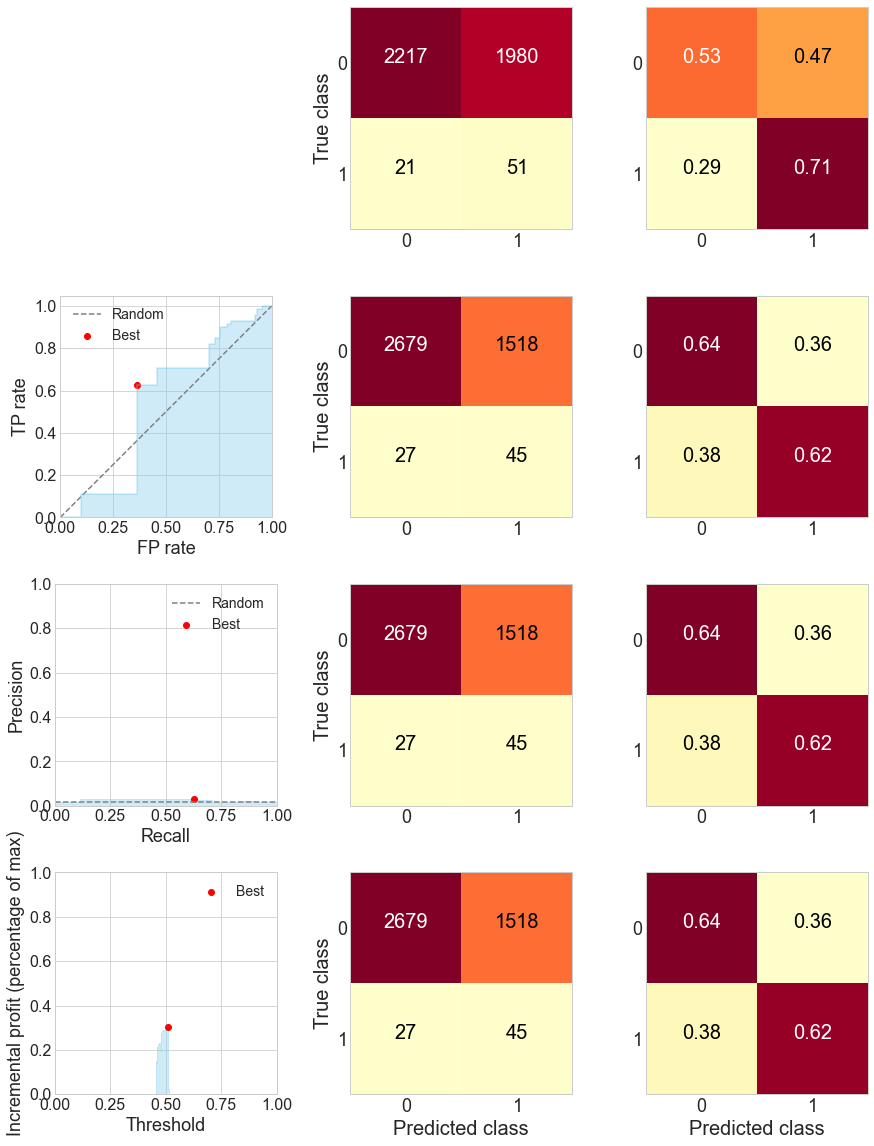

In [24]:
fig, axes = plt.subplots(4,3, figsize=(15,20), gridspec_kw={'hspace': 0.3})
axes[0,0].set_visible(False)
plotMethods.plotCM(cm, normalize=False, ax=axes[0,1], xlabel=False)
plotMethods.plotCM(cm, normalize=True, ax=axes[0,2], xlabel=False, ylabel=False)

_, bestROC = plotMethods.plotROC(Ytest, Yprobs, ax=axes[1,0])
plotMethods.plotCM(confusion_matrix(Ytest, (Yprobs>=bestROC).astype(int)),
                     normalize=False, ax=axes[1,1], xlabel=False)
plotMethods.plotCM(confusion_matrix(Ytest, (Yprobs>=bestROC).astype(int)), 
                     normalize=True, ax=axes[1,2], xlabel=False, ylabel=False)

_, bestPR = plotMethods.plotPR(Ytest, Yprobs, ax=axes[2,0])
plotMethods.plotCM(confusion_matrix(Ytest, (Yprobs>=bestPR).astype(int)), 
                     normalize=False, ax=axes[2,1], xlabel=False)
plotMethods.plotCM(confusion_matrix(Ytest, (Yprobs>=bestPR).astype(int)), 
                     normalize=True, ax=axes[2,2], xlabel=False, ylabel=False)

_, bestProf = plotMethods.plotIncrementalProfit(Ytest, Yprobs, ax=axes[3,0])
plotMethods.plotCM(confusion_matrix(Ytest, (Yprobs>=bestProf).astype(int)), 
                     normalize=False, ax=axes[3,1])
plotMethods.plotCM(confusion_matrix(Ytest, (Yprobs>=bestProf).astype(int)), 
                     normalize=True, ax=axes[3,2], ylabel=False)
fig.tight_layout

In [26]:
plotMethods.metricsTraditional(Ytest, Yprobs, thresholds=[0.5, bestROC, bestPR, bestProf], 
                           columns=['original', 'best ROC', 'best PR', 'best Profit'])

,original,best ROC,best PR,best Profit
AUC,0.62,0.63,0.63,0.63
Precission,0.03,0.03,0.03,0.03
Recall,0.71,0.62,0.62,0.62
F1,0.05,0.06,0.06,0.06
F2,0.11,0.12,0.12,0.12
NIR,205.00,215.00,215.00,215.00
Average NIR per Targeted Customer,0.10,0.04,0.04,0.04


In [27]:
plotMethods.metricsTraditional(Ytrain, xgbPipe.predict_proba(Xtrain)[:,1],
                           thresholds=[0.5, bestROC, bestPR, bestProf], 
                           columns=['original', 'best ROC', 'best PR', 'best Profit'])

,original,best ROC,best PR,best Profit
AUC,0.65,0.63,0.63,0.63
Precission,0.03,0.03,0.03,0.03
Recall,0.78,0.62,0.62,0.62
F1,0.05,0.06,0.06,0.06
F2,0.12,0.12,0.12,0.12
NIR,2274.00,1950.00,1950.00,1950.00
Average NIR per Targeted Customer,0.12,0.16,0.16,0.16


From the above evaluation on an out-of-sample dev set (Xtest and Ytest), we can see that our model performs better than random choice. While the F2 metric is not impressive, it is quite similar across the train and dev set, indicating we are not overfitting our data. The NIR generated by the model is ~2.3 times higher than the one obtained by just targeting all the customers (79.65).

### 2. Random Forest Classifier (bagging)

In [31]:
model = RandomForestClassifier()

rfPipe = make_pipeline(preproc, oversamp, model)

rfParams = {"randomforestclassifier__n_estimators": [800], 
            "randomforestclassifier__class_weight": [{0: 1.0, 1: 1.0}, {0: 1.0, 1: 2.0}, {0: 0.1, 1: 1.0}], 
            "randomforestclassifier__max_depth": range(5,11,1), 
            "randomforestclassifier__min_samples_leaf": [20, 50, 70, 100, 200, 500]
           }

rfStudy = GridSearchCV(rfPipe, param_grid=rfParams, scoring={"AUC": "roc_auc", "F2": f2}, 
                      refit="F2", cv=5, verbose=10)

In [21]:
rfStudy.fit(Xhyper,Yhyper)

joblib.dump(rfStudy, './models/rf-model')  # save model

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=20, randomforestclassifier__n_estimators=800 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=20, randomforestclassifier__n_estimators=800, AUC=0.663, F2=0.315, total=   6.7s
[CV] randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=20, randomforestclassifier__n_estimators=800 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.7s remaining:    0.0s


[CV]  randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=20, randomforestclassifier__n_estimators=800, AUC=0.639, F2=0.311, total=   6.8s
[CV] randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=20, randomforestclassifier__n_estimators=800 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.5s remaining:    0.0s


[CV]  randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=20, randomforestclassifier__n_estimators=800, AUC=0.681, F2=0.309, total=   6.7s
[CV] randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=20, randomforestclassifier__n_estimators=800 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   20.2s remaining:    0.0s


[CV]  randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=20, randomforestclassifier__n_estimators=800, AUC=0.666, F2=0.307, total=   6.9s
[CV] randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=20, randomforestclassifier__n_estimators=800 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   27.1s remaining:    0.0s


[CV]  randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=20, randomforestclassifier__n_estimators=800, AUC=0.634, F2=0.278, total=   7.6s
[CV] randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=50, randomforestclassifier__n_estimators=800 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   34.7s remaining:    0.0s


[CV]  randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=50, randomforestclassifier__n_estimators=800, AUC=0.665, F2=0.313, total=   6.8s
[CV] randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=50, randomforestclassifier__n_estimators=800 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   41.5s remaining:    0.0s


[CV]  randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=50, randomforestclassifier__n_estimators=800, AUC=0.637, F2=0.304, total=   7.0s
[CV] randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=50, randomforestclassifier__n_estimators=800 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   48.5s remaining:    0.0s


[CV]  randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=50, randomforestclassifier__n_estimators=800, AUC=0.676, F2=0.310, total=   6.7s
[CV] randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=50, randomforestclassifier__n_estimators=800 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   55.2s remaining:    0.0s


[CV]  randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=50, randomforestclassifier__n_estimators=800, AUC=0.672, F2=0.293, total=   6.8s
[CV] randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=50, randomforestclassifier__n_estimators=800 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.0min remaining:    0.0s


[CV]  randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=50, randomforestclassifier__n_estimators=800, AUC=0.634, F2=0.269, total=   6.8s
[CV] randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=70, randomforestclassifier__n_estimators=800 
[CV]  randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=70, randomforestclassifier__n_estimators=800, AUC=0.663, F2=0.317, total=   7.6s
[CV] randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=70, randomforestclassifier__n_estimators=800 
[CV]  randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=70, randomforestclassifier__n_estimators=800, AUC=0.6

[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed: 73.1min finished


['rf-model']

In [22]:
rfStudy = joblib.load('./models/rf-model')
rfStudy.best_params_

{'randomforestclassifier__class_weight': {0: 1.0, 1: 2.0},
 'randomforestclassifier__max_depth': 8,
 'randomforestclassifier__min_samples_leaf': 50,
 'randomforestclassifier__n_estimators': 800}

In [33]:
rfPipe.set_params(**rfStudy.best_params_)
rfPipe.fit(Xtrain,Ytrain)
joblib.dump(rfPipe, './models/rf-model-trained')
Ypred = rfPipe.predict(Xtest)
Yprobs = rfPipe.predict_proba(Xtest)[:,1]
cm = confusion_matrix(Ytest, Ypred) 

/Users/paulina/Scripts/repos/machine-learning/target-customers/plotMethods.py:106: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


<bound method Figure.tight_layout of <Figure size 1080x1440 with 12 Axes>>

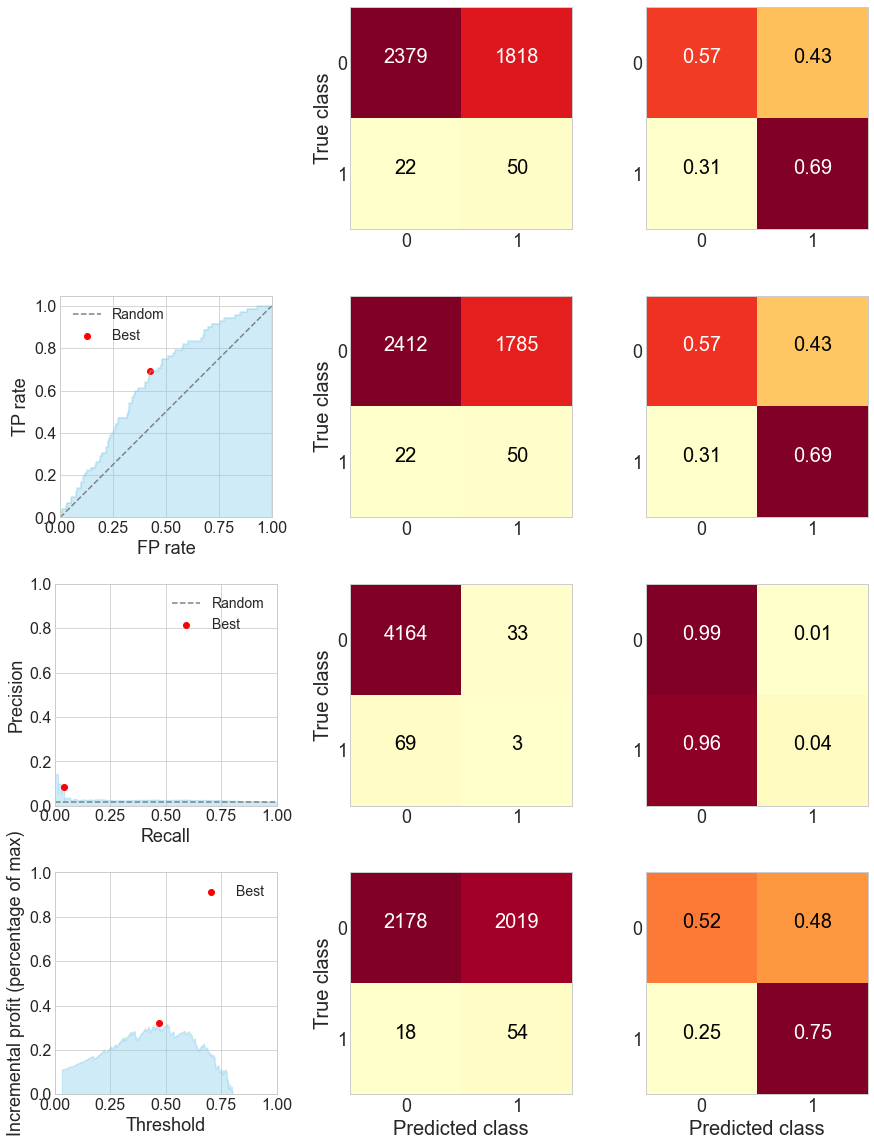

In [36]:
fig, axes = plt.subplots(4,3, figsize=(15,20), gridspec_kw={'hspace': 0.3})
axes[0,0].set_visible(False)
plotMethods.plotCM(cm, normalize=False, ax=axes[0,1], xlabel=False)
plotMethods.plotCM(cm, normalize=True, ax=axes[0,2], xlabel=False, ylabel=False)

_, bestROC = plotMethods.plotROC(Ytest, Yprobs, ax=axes[1,0])
plotMethods.plotCM(confusion_matrix(Ytest, (Yprobs>=bestROC).astype(int)),
                     normalize=False, ax=axes[1,1], xlabel=False)
plotMethods.plotCM(confusion_matrix(Ytest, (Yprobs>=bestROC).astype(int)), 
                     normalize=True, ax=axes[1,2], xlabel=False, ylabel=False)

_, bestPR = plotMethods.plotPR(Ytest, Yprobs, ax=axes[2,0])
plotMethods.plotCM(confusion_matrix(Ytest, (Yprobs>=bestPR).astype(int)), 
                     normalize=False, ax=axes[2,1], xlabel=False)
plotMethods.plotCM(confusion_matrix(Ytest, (Yprobs>=bestPR).astype(int)), 
                     normalize=True, ax=axes[2,2], xlabel=False, ylabel=False)

_, bestProf = plotMethods.plotIncrementalProfit(Ytest, Yprobs, ax=axes[3,0])
plotMethods.plotCM(confusion_matrix(Ytest, (Yprobs>=bestProf).astype(int)), 
                     normalize=False, ax=axes[3,1])
plotMethods.plotCM(confusion_matrix(Ytest, (Yprobs>=bestProf).astype(int)), 
                     normalize=True, ax=axes[3,2], ylabel=False)
fig.tight_layout

In [40]:
plotMethods.metricsTraditional(Ytest, Yprobs, thresholds=[0.5, bestROC, bestPR, bestProf], 
                           columns=['original', 'best ROC', 'best PR', 'best Profit'])

,original,best ROC,best PR,best Profit
AUC,0.63,0.63,0.52,0.63
Precission,0.03,0.03,0.08,0.03
Recall,0.69,0.69,0.04,0.75
F1,0.05,0.05,0.06,0.05
F2,0.12,0.12,0.05,0.11
NIR,219.00,224.00,24.00,229.00
Average NIR per Targeted Customer,0.12,0.12,0.40,0.11


In [42]:
plotMethods.metricsTraditional(Ytrain, rfPipe.predict_proba(Xtrain)[:,1],
                           thresholds=[0.5, bestROC, bestPR, bestProf], 
                           columns=['original', 'best ROC', 'best PR', 'best Profit'])

,original,best ROC,best PR,best Profit
AUC,0.68,0.68,0.52,0.68
Precission,0.03,0.03,0.10,0.03
Recall,0.80,0.79,0.05,0.84
F1,0.06,0.06,0.06,0.06
F2,0.13,0.13,0.05,0.13
NIR,2595.00,2604.00,262.00,2616.00
Average NIR per Targeted Customer,0.15,0.15,0.84,0.14


Random Forest seems to be performing slightly better than the XGBoost, though still generating roughly the same profit.

### 3. Support Vector Machine

In [43]:
model = SVC()
svcPipe = make_pipeline(preproc, oversamp, model)

In [44]:
def objective(trial):
    
    svcParams = {
        "svc__probability": True, 
        "svc__C": trial.suggest_loguniform("svc__C", 1e-3, 1e2),
        "svc__kernel": trial.suggest_categorical("svc__kernel", ['rbf', 'linear', 'poly']),
        "svc__gamma": trial.suggest_loguniform("svc__gamma",1e-3,1e0)
    }
    svcPipe.set_params(**svcParams)
    
    scores = cross_val_score(svcPipe, Xhyper, Yhyper, scoring=f2, cv=5)
    
    return np.mean(scores)

In [14]:
svcStudy = optuna.create_study(direction='maximize')
svcStudy.optimize(objective, n_trials=30)

joblib.dump(svcStudy, './models/svc-model')  # save model

[I 2020-11-10 18:39:51,681] A new study created in memory with name: no-name-ea5e5eef-bb96-4f3b-a193-7c6c7fa54448


In [20]:
svcStudy = joblib.load('./models/svc-model')
svcStudy.best_params

{'svc__C': 0.11916377362861046,
 'svc__gamma': 0.11352928589738281,
 'svc__kernel': 'rbf'}

In [45]:
svcPipe.set_params(**svcStudy.best_params)
svcPipe.fit(Xtrain,Ytrain)
joblib.dump(svcPipe, './models/svc-model-trained')
Ypred = svcPipe.predict(Xtest)
Yprobs = svcPipe.decision_function(Xtest)
cm = confusion_matrix(Ytest, Ypred) 

/Users/paulina/Scripts/repos/machine-learning/target-customers/plotMethods.py:106: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


<bound method Figure.tight_layout of <Figure size 1080x1440 with 12 Axes>>

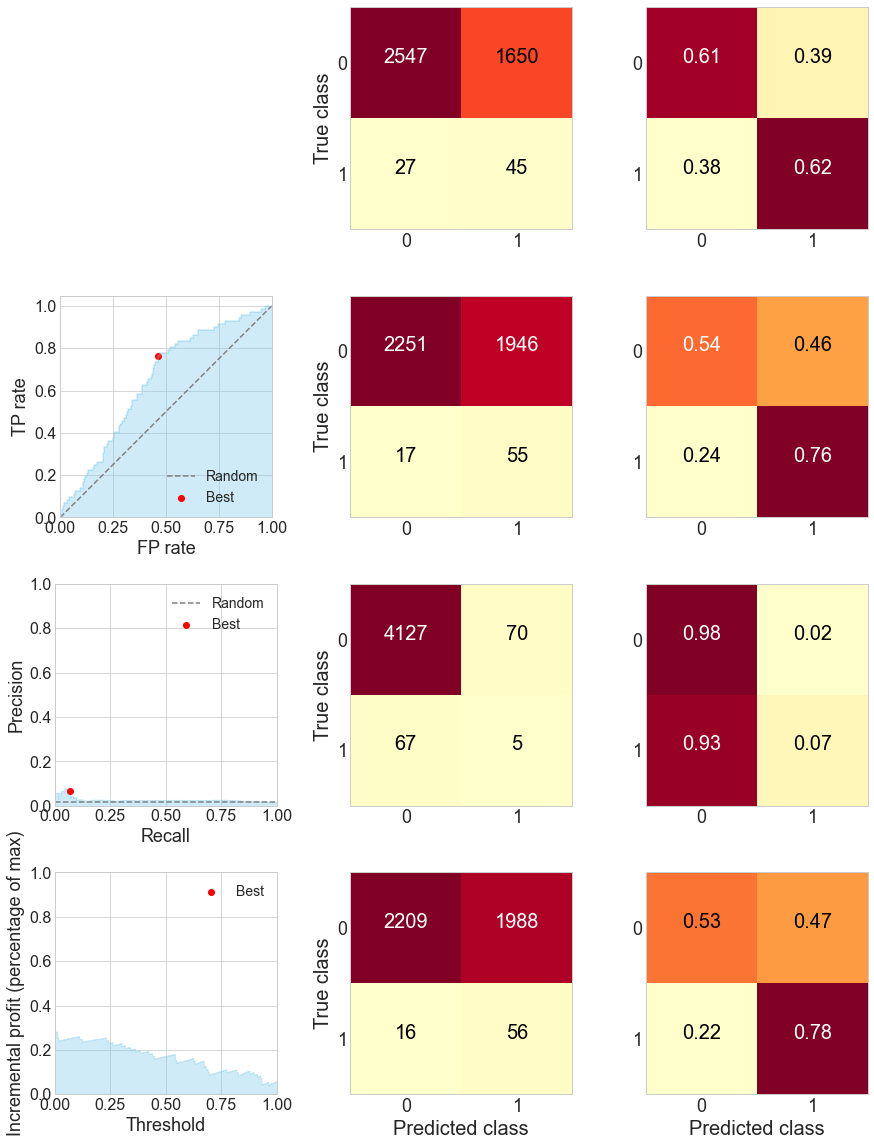

In [47]:
fig, axes = plt.subplots(4,3, figsize=(15,20), gridspec_kw={'hspace': 0.3})
axes[0,0].set_visible(False)
plotMethods.plotCM(cm, normalize=False, ax=axes[0,1], xlabel=False)
plotMethods.plotCM(cm, normalize=True, ax=axes[0,2], xlabel=False, ylabel=False)

_, bestROC = plotMethods.plotROC(Ytest, Yprobs, ax=axes[1,0])
plotMethods.plotCM(confusion_matrix(Ytest, (Yprobs>=bestROC).astype(int)),
                     normalize=False, ax=axes[1,1], xlabel=False)
plotMethods.plotCM(confusion_matrix(Ytest, (Yprobs>=bestROC).astype(int)), 
                     normalize=True, ax=axes[1,2], xlabel=False, ylabel=False)

_, bestPR = plotMethods.plotPR(Ytest, Yprobs, ax=axes[2,0])
plotMethods.plotCM(confusion_matrix(Ytest, (Yprobs>=bestPR).astype(int)), 
                     normalize=False, ax=axes[2,1], xlabel=False)
plotMethods.plotCM(confusion_matrix(Ytest, (Yprobs>=bestPR).astype(int)), 
                     normalize=True, ax=axes[2,2], xlabel=False, ylabel=False)

_, bestProf = plotMethods.plotIncrementalProfit(Ytest, Yprobs, ax=axes[3,0])
plotMethods.plotCM(confusion_matrix(Ytest, (Yprobs>=bestProf).astype(int)), 
                     normalize=False, ax=axes[3,1])
plotMethods.plotCM(confusion_matrix(Ytest, (Yprobs>=bestProf).astype(int)), 
                     normalize=True, ax=axes[3,2], ylabel=False)
fig.tight_layout

In [48]:
plotMethods.metricsTraditional(Ytest, Yprobs, Ypred=Ypred, thresholds=[bestROC, bestPR, bestProf], 
                           columns=['original', 'best ROC', 'best PR', 'best Profit'])

,original,best ROC,best PR,best Profit
AUC,0.62,0.65,0.53,0.65
Precission,0.03,0.03,0.07,0.03
Recall,0.62,0.76,0.07,0.78
F1,0.05,0.05,0.07,0.05
F2,0.11,0.12,0.07,0.12
NIR,195.00,249.00,38.00,253.00
Average NIR per Targeted Customer,0.12,0.12,0.38,0.12


In [49]:
plotMethods.metricsTraditional(Ytrain, svcPipe.decision_function(Xtrain), 
                           Ypred=svcPipe.predict(Xtrain), thresholds=[bestROC, bestPR, bestProf], 
                           columns=['original', 'best ROC', 'best PR', 'best Profit'])

,original,best ROC,best PR,best Profit
AUC,0.67,0.67,0.52,0.66
Precission,0.03,0.03,0.04,0.03
Recall,0.74,0.81,0.05,0.82
F1,0.06,0.05,0.05,0.05
F2,0.13,0.12,0.05,0.12
NIR,2456.00,2489.00,210.00,2444.00
Average NIR per Targeted Customer,0.16,0.13,0.26,0.13


SVC performed slightly worst that the remaining two models, but still giving very similar outcomes in terms of NIR and F2 metrics. Our **best performing** model here is the **random forest**. Before we get to making any predictions on the the test dataset though, let's see how the remaining uplift modeling approaches are doing:

1. [S-learner model (one-model "uplift classifier")](./2.S-learner.ipynb)
2. [T-learner model (two-models "uplift classifier")](./3.T-learner.ipynb) 
3. [Direct uplift modeling](./4.Direct-uplift.ipynb)